# DMS alpha- synuclein

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import torch
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler

## Data pre-processing

In [2]:
data = pd.read_excel('data/cb0c00339_si_002.xlsx', index_col=0)
data

,W,Y,F,L,I,V,M,C,A,G,P,S,T,N,Q,H,R,K,D,E
1,0.645631,0.384739,0.643215,0.628082,0.607942,NaN,0.000000,0.640626,0.604611,0.599873,0.633575,NaN,NaN,0.629992,0.624209,0.637284,0.637986,0.643052,0.639739,0.629064
2,0.188657,0.034327,-0.055355,-0.056184,0.136754,0.430195,0.055314,0.060914,0.223995,0.410560,0.264693,0.157764,NaN,-0.063598,-0.018077,0.015558,0.257129,0.180277,0.000000,0.238997
3,0.139869,0.184946,0.062915,0.040844,0.108747,0.000000,0.029829,0.118255,0.110775,0.235237,0.572019,0.080056,0.427101,0.086428,0.096089,0.078165,-0.074486,0.190046,0.242486,0.409446
4,0.053232,0.000000,0.274371,0.030018,0.021271,0.194697,0.111909,0.219058,0.483499,0.551050,0.595786,0.526108,0.535909,0.496316,0.532204,NaN,0.519989,0.519161,0.370481,0.530801
5,0.035749,0.268188,0.096598,0.514890,0.459631,0.001480,0.000000,0.241395,0.146913,0.295428,0.608295,0.145951,0.290156,0.156247,0.470298,0.546305,-0.049651,-0.002347,0.454796,0.401479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,-0.017798,-0.006899,0.000000,0.001461,0.005656,0.010760,0.001087,0.007314,0.052456,0.039369,0.016958,-0.039147,0.041608,0.093290,0.014847,0.014390,0.027483,0.005113,0.186374,0.085998
137,0.024781,0.016178,-0.000680,0.017183,0.074224,0.055461,0.056399,0.020844,0.015159,0.025180,0.060228,-0.004795,0.054438,0.064648,0.043943,0.016748,-0.000306,0.069250,0.004428,0.000000
138,-0.007228,-0.008825,0.020536,0.057790,0.064414,0.007807,0.027238,-0.004019,-0.006004,-0.017850,0.000000,0.000191,0.035842,0.080669,0.061661,0.045439,0.044046,0.053950,0.031880,0.078690
139,0.011899,-0.026113,-0.033153,0.047468,-0.019269,-0.007792,0.030250,0.133334,0.017327,0.031511,0.058277,-0.014332,0.096514,-0.015149,0.054441,0.035881,0.012031,-0.000441,0.015724,0.000000


In [3]:
# wt_seq = []
# for row in data.iterrows():
#     if 0 in row[1].values:
#         wt = row[1][row[1] == 0].index[0]
#         wt_seq.append(wt)

# a_syn_rec = ''.join(wt_seq)
# a_syn_rec

In [4]:
a_syn = 'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA'
# transvertions = []
# for i in range(len(a_syn)):
#     if  wt_seq[i]!= a_syn[i]:
#         transvertions.append(wt_seq[i]+ str(i)+a_syn[i])

# transvertions

In [5]:
muts_effect = {}
for column in data.columns:
    for index, row in data.iterrows():
        mut = a_syn[index-1] + str(index) + column
        muts_effect[mut]= data.loc[index, column]
  

meta_data = pd.DataFrame.from_dict(muts_effect, orient='index').reset_index()
meta_data.rename(columns={'index':'mutation', 0:'effect'}, inplace=True)
meta_data.dropna(inplace=True)
meta_data

,mutation,effect
0,M1W,0.645631
1,D2W,0.188657
2,V3W,0.139869
3,F4W,0.053232
4,M5W,0.035749
...,...,...
2795,Y136E,0.085998
2796,E137E,0.000000
2797,P138E,0.078690
2798,E139E,0.000000


In [6]:
import re

def mutated_seqs(wt_seq, mutation):
    wt_AA, position, mut_AA = re.findall(r'[A-Za-z]+|\d+', mutation)
    coor = int(position)-1
    
    if wt_AA == mut_AA:
        mutated_seq = ''
    elif wt_seq[coor] == wt_AA:
        mutated_seq = wt_seq[:coor] + mut_AA + wt_seq[coor+1:]
    elif wt_seq[coor] != wt_AA:
        mutated_seq = ''
    else:
        print(f'Error: {wt_AA} is not the amino acid at position {position}.')

    return mutated_seq


mutated_seqs(a_syn, 'Y93F')


''

In [7]:
meta_data['mutated_seq'] = meta_data['mutation'].apply(lambda x: mutated_seqs(a_syn, x))
meta_data.query('mutated_seq != ""', inplace=True)
meta_data

,mutation,effect,mutated_seq
0,M1W,0.645631,WDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,D2W,0.188657,MWVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,V3W,0.139869,MDWFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,F4W,0.053232,MDVWMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,M5W,0.035749,MDVFWKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
...,...,...,...
2793,Q134E,0.042210,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2794,D135E,-0.031937,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2795,Y136E,0.085998,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2797,P138E,0.078690,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


In [8]:
new_row = pd.DataFrame.from_dict({'mutation':'WT', 'effect':0, 'mutated_seq':a_syn}, orient='index').T

meta_data = pd.concat([new_row, meta_data]).reset_index(drop=True) 
meta_data

,mutation,effect,mutated_seq
0,WT,0,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,M1W,0.645631,WDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,D2W,0.188657,MWVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,V3W,0.139869,MDWFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,F4W,0.053232,MDVWMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
...,...,...,...
2499,Q134E,0.04221,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2500,D135E,-0.031937,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2501,Y136E,0.085998,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2502,P138E,0.07869,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


In [11]:
#meta_data.to_csv('data/a-syn_DMS_meta_data.csv', index=False)

In [9]:
# with open('data/a_syn_DMS_sequences.fasta', 'w') as f:
#     for ID, seq in zip(meta_data.mutation, meta_data.mutated_seq):
#         f.write(f'>{ID}\n{seq}\n')

## Machine Learning

In [3]:
## load meta data
meta_data = pd.read_csv('data/a-syn_DMS_meta_data.csv')
meta_data

,mutation,effect,mutated_seq
0,WT,0.000000,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,M1W,0.645631,WDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,D2W,0.188657,MWVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,V3W,0.139869,MDWFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,F4W,0.053232,MDVWMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
...,...,...,...
2499,Q134E,0.042210,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2500,D135E,-0.031937,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2501,Y136E,0.085998,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2502,P138E,0.078690,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


### Using esm2 to extract embeddings

In [ ]:
#python scripts/extract.py esm2_t30_150M_UR50D data/a_syn_DMS_sequences.fasta embeddings/ --include mean

### Loading embeddings

In [4]:
def load_mean_embeds(dir_path):
    '''Iterate over the layers embeddings splited and load the embeddings per layer'''
     # list of all files containing the embeddings and created a dictionary
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    embeddings = {}
    for file in os.listdir(dir_path):
        if file.endswith('.pt'):
            file_path = os.path.join(dir_path, file)
            label = file.split('.pt')[0]
            embeddings[label] = np.array(torch.load(file_path)['mean_representations'][30])

    # convert to array type sequences_embeddings to a data frame
    df=pd.DataFrame.from_dict(embeddings, orient='index').reset_index()
    df.rename(columns={'index':'mutation'}, inplace=True)
    return df

In [5]:
embeds = load_mean_embeds('embeddings/a-syn_DMS_esm2_150M_mean/')
data = meta_data.merge(embeds, on='mutation', how='inner')
data

,mutation,effect,mutated_seq,0,1,2,3,4,5,6,...,630,631,632,633,634,635,636,637,638,639
0,WT,0.000000,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.087509,-0.141573,-0.045375,0.147647,0.033079,0.006423,0.054152,...,-0.099348,-0.043451,-0.344581,-0.167214,0.044787,0.155121,0.010069,-0.010588,0.039759,-0.029401
1,M1W,0.645631,WDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.090933,-0.153992,-0.042397,0.145299,0.034432,0.005734,0.048089,...,-0.104135,-0.049668,-0.337335,-0.159240,0.044105,0.158015,0.019436,-0.006092,0.025239,-0.031818
2,D2W,0.188657,MWVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.082556,-0.128089,-0.047340,0.150281,0.032487,0.003248,0.046689,...,-0.100386,-0.038188,-0.347550,-0.166431,0.036915,0.153154,0.010328,-0.006035,0.050581,-0.021108
3,V3W,0.139869,MDWFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.084100,-0.128871,-0.052628,0.156018,0.042377,0.004063,0.058364,...,-0.098583,-0.042095,-0.349069,-0.176929,0.053934,0.148816,0.005886,-0.018491,0.050297,-0.019814
4,F4W,0.053232,MDVWMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.088567,-0.150872,-0.034862,0.137815,0.031768,0.002539,0.052404,...,-0.099022,-0.045338,-0.341825,-0.160897,0.045057,0.152263,0.013747,-0.009967,0.030347,-0.033513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,Q134E,0.042210,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.084843,-0.134074,-0.043362,0.153934,0.035164,0.009269,0.053370,...,-0.097078,-0.037660,-0.346975,-0.162851,0.046984,0.152138,0.007908,-0.006641,0.041838,-0.031886
2500,D135E,-0.031937,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.090307,-0.141505,-0.044951,0.144684,0.031088,0.003180,0.051620,...,-0.101185,-0.043925,-0.340361,-0.162881,0.046856,0.157510,0.010811,-0.007872,0.034212,-0.030766
2501,Y136E,0.085998,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.070960,-0.133653,-0.046690,0.150734,0.030844,0.010397,0.052741,...,-0.092509,-0.040589,-0.364932,-0.164128,0.038324,0.152684,0.002551,-0.006389,0.040506,-0.027303
2502,P138E,0.078690,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.078912,-0.135841,-0.044238,0.145504,0.038064,0.011989,0.050778,...,-0.097606,-0.038808,-0.339996,-0.171923,0.049432,0.154854,0.008508,-0.001956,0.046822,-0.026920


In [6]:
def features_scaler(features):
    '''Scale the features by min-max scaler, to ensure that the features selected by Lasso are not biased by the scale of the features'''
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_features = scaler.fit_transform(features)
    return pd.DataFrame(scaled_features)

In [7]:
features = data.iloc[:, meta_data.shape[1]:]
features = features_scaler(features)
features

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,0.215951,0.341656,-0.281034,0.092278,-0.021826,0.253842,0.147237,0.058727,0.049915,-0.057312,...,-0.180845,-0.129876,-0.157825,-0.066151,0.153621,-0.113787,-0.044261,0.133226,0.301723,0.261288
1,0.356272,-0.049565,-0.161278,0.014975,0.029972,0.218914,-0.129318,0.371600,0.200976,-0.036421,...,-0.441126,-0.386486,-0.003530,0.206214,0.124029,0.087315,0.329788,0.342473,-0.130480,0.175726
2,0.012953,0.766415,-0.360031,0.178987,-0.044443,0.092858,-0.193200,-0.076107,-0.039034,-0.269836,...,-0.237325,0.087386,-0.221055,-0.039395,-0.188107,-0.250467,-0.033930,0.345132,0.623824,0.554980
3,0.076244,0.741774,-0.572660,0.367840,0.333959,0.134179,0.339324,-0.095549,-0.432692,-0.049725,...,-0.139248,-0.073871,-0.253397,-0.397970,0.550678,-0.551857,-0.211312,-0.234565,0.615392,0.600788
4,0.259296,0.048693,0.141685,-0.231370,-0.071980,0.056923,0.067500,-0.060841,0.043196,-0.107821,...,-0.163105,-0.207746,-0.099146,0.149607,0.165351,-0.312369,0.102632,0.162163,0.021550,0.115686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,0.106695,0.577861,-0.200084,0.299255,0.057958,0.398132,0.111531,0.123224,0.175738,-0.140938,...,-0.057433,0.109170,-0.208807,0.082864,0.249000,-0.321041,-0.130547,0.316949,0.363584,0.173314
2500,0.330602,0.343799,-0.263999,-0.005259,-0.097973,0.089414,0.031717,0.147293,-0.023467,0.072365,...,-0.280770,-0.149439,-0.067970,0.081836,0.243457,0.052205,-0.014624,0.259622,0.136596,0.212971
2501,-0.462265,0.591131,-0.333916,0.193886,-0.107341,0.455305,0.082868,0.223213,0.379301,0.132143,...,0.191039,-0.011707,-0.591190,0.039248,-0.126946,-0.283080,-0.344462,0.328678,0.323946,0.335577
2502,-0.136360,0.522205,-0.235303,0.021739,0.168933,0.536035,-0.006665,0.044003,0.048621,-0.101042,...,-0.086151,0.061789,-0.060193,-0.226997,0.355246,-0.132312,-0.106610,0.534955,0.511953,0.349153


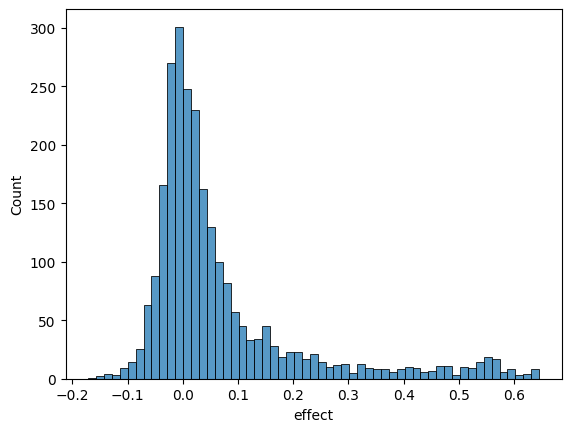

In [8]:
target = data['effect']
sns.histplot(target)
plt.show()  

In [66]:
def run_regression_v2(features, target):
    '''this version computes y_pred for train and test sets'''
    # Initialize lists for storing results
    folds = []
    r2s_train,  maes_train, rmses_train = [], [], []
    r2s_test, maes_test, rmses_test = [], [], []

    predictions = {'actual': [], 'predicted': []}

    # Define the KFold cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Loop over the KFold splits
    for kfold, (train_index, test_index) in enumerate(kf.split(features)):
        # Split the data into training and testing sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Define and train the regression model
        model = Lasso(alpha=0.0001, random_state=42, max_iter=10000, tol=0.001)
        model.fit(X_train, y_train)


        # Make predictions
        y_pred_train = pd.DataFrame(model.predict(X_train))
        y_pred_test = pd.DataFrame(model.predict(X_test))

        predictions['actual'].extend(y_test.values)
        predictions['predicted'].extend(y_pred_test.values)



        # Evaluate the model
        r2_train = metrics.r2_score(y_train, y_pred_train)
        mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
        mse_train = metrics.mean_squared_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mse_train)

        r2_test = metrics.r2_score(y_test, y_pred_test)
        mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        

        # Append results
        r2s_train.append(r2_train)
        maes_train.append(mae_train)
        rmses_train.append(rmse_train)

        r2s_test.append(r2_test)
        maes_test.append(mae_test)
        rmses_test.append(rmse_test)

        folds.append(kfold + 1)

        #print(f"Fold {kfold + 1}, R2 (train): {r2_train:.2f}, R2 (test): {r2_test:.2f},")

       

    # Return the collected results
    return folds, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, predictions


def save_results_v2(folds, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test):
    # Create dictionary for results
    res_dict = {
        "Model": ['Lasso'] * 10,
        "Fold": folds,
        "R2_score_train": r2s_train,
        "MAE_score_train": maes_train,
        "RMSE_score_train": rmses_train,
        "R2_score_test": r2s_test,
        "MAE_score_test": maes_test,
        "RMSE_score_test": rmses_test,
    }

    # Convert results to DataFrame
    results = pd.DataFrame(res_dict).reset_index(drop=True)
    return results

In [67]:
folds, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, predictions = run_regression_v2(features, target)
save_results_v2(folds, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test)

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test
0,Lasso,1,0.817976,0.046190,0.062920,0.740548,0.048197,0.066111
1,Lasso,2,0.818457,0.045693,0.062135,0.743096,0.051995,0.073970
2,Lasso,3,0.810090,0.045583,0.062620,0.819341,0.051039,0.069562
3,Lasso,4,0.816259,0.045931,0.062889,0.758848,0.051988,0.067228
4,Lasso,5,0.817200,0.045862,0.062433,0.743106,0.053330,0.073057
5,Lasso,6,0.814508,0.046090,0.063307,0.793762,0.047341,0.061282
6,Lasso,7,0.817145,0.045583,0.062502,0.735364,0.055570,0.073516
7,Lasso,8,0.806487,0.046502,0.063493,0.844054,0.046265,0.062503
8,Lasso,9,0.817903,0.046257,0.063099,0.740643,0.045436,0.064087
9,Lasso,10,0.816526,0.045223,0.061340,0.743798,0.058887,0.084157


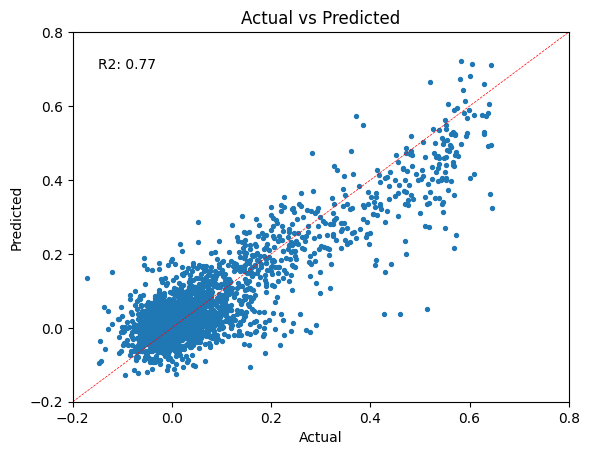

In [103]:
#sns.scatterplot(x=predictions['actual'], y=predictions['predicted'])
plt.scatter(predictions['actual'], predictions['predicted'], s=8)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.ylim(-0.2, 0.8)
plt.xlim(-0.2, 0.8)
plt.plot([-0.2, 0.8], [-0.2, 0.8], color='red', linestyle='--', linewidth=0.5)
plt.text(-0.15, 0.7, f'R2: {np.mean(r2s_test):.2f}', fontsize=10)
plt.show()